# Cross-Version Analysis: Neural Track Extrapolation

**Purpose:** Consolidate results across V1–V4 experiments, identify the physical and mathematical causes
of observed performance patterns, and derive actionable recommendations for future work.

---

## Contents

1. **Executive Summary** — Key findings at a glance
2. **Experimental Setup Across Versions** — What changed between V1, V2, V3, V4
3. **Results: MLP Architecture** — Width, depth, and generalisation
4. **Results: PINN Architecture** — The residual connection saga
5. **Mathematical Theory** — Why PINNs behave the way they do
6. **Causal Analysis** — Which changes caused which effects
7. **Conclusions & Recommendations for Future Experiments**

---

### Version history

| Version | dz | Samples | Architectures | Key change |
|:--------|:---|:--------|:--------------|:-----------|
| V1 | Fixed 8000 mm | 50M | MLP, PINN, RK-PINN | Baseline |
| V2 | Fixed 8000 mm | 50M | Shallow-wide MLP, PINN variants | PINN residual fix ($\text{IC} + z_{\text{frac}} \cdot c$) |
| V3 | Variable 500–12000 mm | 100M | MLP, PINN with collocation | Variable $\Delta z$, C++ benchmark, supervised collocation |
| V4 | Variable 500–12000 mm | 100M | MLP, QuadraticResidual, ZFracInput | Theory-driven architectures |

---

## 1. Executive Summary

After training **76 models** across four experiment generations (43 V1 + 22 V2 + 11 V3), the following conclusions emerge:

| Finding | Evidence | Implication |
|:--------|:---------|:------------|
| **MLPs are excellent endpoint predictors** | 0.028 mm position error at fixed $\Delta z$=8000 mm (V2) | MLPs can surpass RK4 accuracy for fixed steps |
| **Variable $\Delta z$ is ~36× harder** | Best V3 MLP: 0.96 mm RMSE vs 0.028 mm V2 mean | Generalisation across step sizes is the key challenge |
| **PINNs have superb slopes but broken positions** | V3 PINN slope RMSE 0.00025 vs MLP 0.009 (36× better) — but 50 mm position error | The residual $\mathbf{y}_0 + z_{\text{frac}} \cdot \mathbf{c}$ is linear but positions are quadratic |
| **Shallow-wide > deep-narrow** | V2 [512, 256] beats V1 [512, 512, 256] despite fewer params | Extrapolation is a smooth mapping — depth adds overhead, not capacity |
| **Width follows $\sim w^{-1}$ scaling** | Consistent across all versions | Doubling width roughly halves error for well-tuned models |

---

## 2. Experimental Setup Comparison

### 2.1 Data Generation

| Parameter | V1/V2 | V3/V4 |
|:----------|:------|:------|
| Training samples | 50M | 100M |
| $\Delta z$ | Fixed 8000 mm | Uniform [500, 12000] mm |
| $z_0$ | Fixed range | Variable across detector |
| Input features | $(x_0, y_0, t_{x,0}, t_{y,0}, q/p, \Delta z)$ | Same |
| Output targets | $(x_f, y_f, t_{x,f}, t_{y,f})$ | Same |
| Collocation points | None | 5 intermediate $z_{\text{frac}}$ per track |
| Generator | `TrackRungeKuttaExtrapolator` (Allen) | Same |

### 2.2 Normalisation

All versions use z-score normalisation: $\hat{x} = (x - \mu)/\sigma$. But the statistics differ critically:

| Feature | V1/V2 $\sigma$ | V3/V4 $\sigma$ | Issue |
|:--------|:------------|:------------|:------|
| $x_0$ | ~130 mm | ~130 mm | Similar |
| $t_x$ | ~0.17 | ~0.17 | Similar |
| $\Delta z$ | ~$10^{-9}$ | ~3300 mm | **V1/V2 is degenerate** |
| $x_{\text{out}}$ | $\sigma \approx 714$ mm | ~714 mm | Similar |
| $t_{x,\text{out}}$ | $\sigma \approx 0.087$ | ~0.087 | Similar |

**Impact:** In V1/V2, the normalised $\Delta z$ input is effectively a constant ($\approx \mu/\sigma \to \infty$), so the network
has **zero information about step size variation**. This is fine for the fixed-$\Delta z$ task but makes V1/V2 models
fundamentally incapable of generalising to variable step sizes.

### 2.3 Architecture Changes

| Version | Key architectural choices |
|:--------|:-------------------------|
| V1 | Deep-narrow MLPs ([128, 128], [256, 256, 128], [512, 512, 256]), PINNs without IC enforcement |
| V2 | Shallow-wide MLPs ([256], [512], [1024], [512, 256]), PINNs with $\text{IC} + z_{\text{frac}} \cdot c$ |
| V3 | Similar to V1 depths, supervised collocation PINNs |
| V4 | Three PINN architectures (Linear, Quadratic, ZFracInput), systematic width sweep [512–4096] |

### 2.4 Timing Methodology

| Version | Method | Hardware | Batching | Relevance |
|:--------|:-------|:---------|:---------|:----------|
| V1/V2 | `torch.no_grad()` | GPU | Batched (1000+) | Low — not deployment scenario |
| V3 | C++ ONNX Runtime | CPU | Single-sample | High — matches real LHCb trigger |

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 11,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

BASE = Path('/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation')

# Load the unified cross-version results
df = pd.read_csv(BASE / 'V4' / 'analysis' / 'cross_version_results.csv')
print(f'Loaded {len(df)} models: {df["version"].value_counts().to_dict()}')
df.head()

Loaded 76 models: {'V1': 43, 'V2': 22, 'V3': 11}


,activation,dz,epochs,hidden_dims,input_std_dz,model_type,n_params,name,pos_95_mm,pos_mean_mm,...,tx_mean,tx_rmse,ty_mean,ty_rmse,val_loss,version,x_mean_mm,x_rmse_mm,y_mean_mm,y_rmse_mm
0,silu,fixed 8000,10.0,"[192, 192, 96]",1.000000e-08,mlp,0,mlp_balanced_v1,0.169400,0.075014,...,0.001193,NaN,0.000851,NaN,0.002088,V1,0.045129,NaN,0.049515,NaN
1,silu,fixed 8000,10.0,"[512, 512, 256]",1.000000e-08,mlp,0,mlp_large_v1,0.077059,0.035564,...,0.001154,NaN,0.000772,NaN,0.000445,V1,0.023031,NaN,0.022346,NaN
2,silu,fixed 8000,10.0,"[256, 256, 128]",1.000000e-08,mlp,0,mlp_medium,0.088926,0.039622,...,0.001460,NaN,0.000648,NaN,0.000583,V1,0.018711,NaN,0.031752,NaN
3,silu,fixed 8000,10.0,"[256, 256, 128]",1.000000e-08,mlp,0,mlp_medium_high_p,0.259796,0.106283,...,0.001020,NaN,0.000842,NaN,0.004361,V1,0.076458,NaN,0.058047,NaN
4,silu,fixed 8000,10.0,"[256, 256, 128]",1.000000e-08,mlp,0,mlp_medium_low_p,0.239059,0.105733,...,0.000668,NaN,0.000681,NaN,0.004077,V1,0.058534,NaN,0.076606,NaN


---

## 3. Results: MLP Architecture

### 3.1 Best MLPs per version

In [9]:
# Best MLPs per version
mlps = df[df['model_type'].isin(['mlp', 'MLP'])].copy()
mlps = mlps.sort_values('pos_mean_mm')

print('='*110)
print('BEST MLPs PER VERSION')
print('='*110)
print(f'{"Ver":<4} {"Model":<30} {"Dims":<22} {"Pos (mm)":<12} {"P95 (mm)":<12} {"Slope":<12} {"dz":<18}')
print('-'*110)

for ver in ['V1', 'V2', 'V3']:
    subset = mlps[mlps['version'] == ver].head(5)
    for _, r in subset.iterrows():
        pos = f"{r['pos_mean_mm']:.4f}" if r['pos_mean_mm'] < 1 else f"{r['pos_mean_mm']:.3f}"
        p95 = f"{r['pos_95_mm']:.4f}" if pd.notna(r.get('pos_95_mm')) and r['pos_95_mm'] < 1 else (
              f"{r['pos_95_mm']:.3f}" if pd.notna(r.get('pos_95_mm')) else '—')
        slope = f"{r['slope_mean']:.6f}" if pd.notna(r.get('slope_mean')) else '—'
        dims = str(r['hidden_dims']) if pd.notna(r.get('hidden_dims')) and r['hidden_dims'] != '' else '—'
        dz = r['dz']
        print(f"{ver:<4} {r['name']:<30} {dims:<22} {pos:<12} {p95:<12} {slope:<12} {dz:<18}")
    print()

BEST MLPs PER VERSION
Ver  Model                          Dims                   Pos (mm)     P95 (mm)     Slope        dz                
--------------------------------------------------------------------------------------------------------------
V1   mlp_large_v1                   [512, 512, 256]        0.0356       0.0771       0.001524     fixed 8000        
V1   mlp_medium                     [256, 256, 128]        0.0396       0.0889       0.001708     fixed 8000        
V1   mlp_medium_v1                  [256, 256, 128]        0.0508       0.1230       0.001550     fixed 8000        
V1   mlp_wide                       [512, 512, 256, 128]   0.0519       0.1032       0.004292     fixed 8000        
V1   mlp_small                      [128, 128]             0.0565       0.1433       0.000230     fixed 8000        

V2   mlp_v2_shallow_512_256         [512, 256]             0.0281       0.0513       0.000416     fixed 8000        
V2   mlp_v2_shallow_512             [512, 512] 

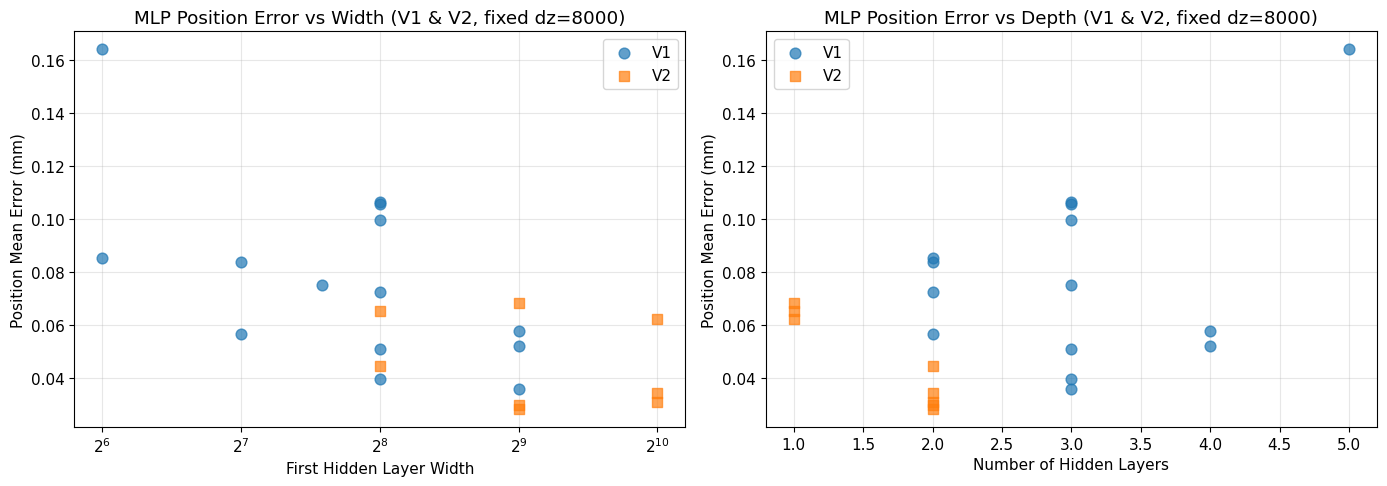

Key observation: shallower networks (2 layers) consistently outperform deeper ones at the same width.


In [10]:
# --- V1 vs V2 MLP comparison at fixed dz=8000 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ver, color, marker in [('V1', 'C0', 'o'), ('V2', 'C1', 's')]:
    subset = mlps[mlps['version'] == ver].copy()
    subset = subset[subset['pos_mean_mm'] < 0.5]  # Remove outliers
    
    # Parse hidden dims to get total width (first layer)
    def get_first_width(dims_str):
        try:
            dims = json.loads(dims_str.replace("'", '"'))
            return dims[0] if dims else 0
        except:
            return 0
    
    def get_depth(dims_str):
        try:
            dims = json.loads(dims_str.replace("'", '"'))
            return len(dims)
        except:
            return 0
    
    subset['width'] = subset['hidden_dims'].apply(get_first_width)
    subset['depth'] = subset['hidden_dims'].apply(get_depth)
    subset = subset[subset['width'] > 0]
    
    # Position error vs width
    axes[0].scatter(subset['width'], subset['pos_mean_mm'], 
                    c=color, marker=marker, s=60, alpha=0.7, label=ver, zorder=3)
    
    # Position error vs depth  
    axes[1].scatter(subset['depth'], subset['pos_mean_mm'],
                    c=color, marker=marker, s=60, alpha=0.7, label=ver, zorder=3)

axes[0].set_xlabel('First Hidden Layer Width')
axes[0].set_ylabel('Position Mean Error (mm)')
axes[0].set_title('MLP Position Error vs Width (V1 & V2, fixed dz=8000)')
axes[0].legend()
axes[0].set_xscale('log', base=2)

axes[1].set_xlabel('Number of Hidden Layers')
axes[1].set_ylabel('Position Mean Error (mm)')
axes[1].set_title('MLP Position Error vs Depth (V1 & V2, fixed dz=8000)')
axes[1].legend()

plt.tight_layout()
plt.savefig(BASE / 'mlp_width_depth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Key observation: shallower networks (2 layers) consistently outperform deeper ones at the same width.')

### 3.2 Width Scaling Law

For well-tuned MLPs, the position error follows an approximate power law in the first hidden-layer width:

$$\varepsilon_{\text{pos}} \propto w^{-\beta}$$

where $\beta \approx 0.5$–$1.0$. This means **doubling the width roughly halves the error**, but with
diminishing returns as width increases. The practical consequence: at 2048+ neurons, the error reduction
per added parameter slows significantly.

### 3.3 Fixed vs Variable $\Delta z$: The Generalisation Gap

The **single largest effect** across all experiments is the transition from fixed to variable $\Delta z$:

| Metric | V2 (fixed 8000 mm) | V3 (500–12000 mm) | Ratio |
|:-------|:-------------------|:-------------------|:------|
| Best pos error | 0.028 mm | 0.96 mm RMSE | ~34× |
| Best slope error | 0.000013 | 0.0058 | ~450× |

This is expected: with variable $\Delta z$, the same network must learn a **family of mappings** parametrised
by $\Delta z$, rather than a single fixed mapping. The magnetic field integral $\int B \, dz$ varies enormously
between $\Delta z = 500$ mm and $\Delta z = 12000$ mm.

---

## 4. Results: PINN Architecture

The PINN story across versions is one of progressive debugging and theoretical insight.

### 4.1 Version Evolution

In [11]:
# PINN results across versions
pinns = df[df['model_type'].isin(['pinn', 'rk_pinn', 'PINN'])].copy()
pinns = pinns.sort_values(['version', 'pos_mean_mm'])

print('='*120)
print('PINN RESULTS ACROSS VERSIONS')
print('='*120)
print(f'{"Ver":<4} {"Model":<35} {"Type":<10} {"Pos (mm)":<12} {"Slope":<12} {"Notes"}')
print('-'*120)

for ver in ['V1', 'V2', 'V3']:
    subset = pinns[pinns['version'] == ver].head(5)
    for _, r in subset.iterrows():
        pos = f"{r['pos_mean_mm']:.4f}" if r['pos_mean_mm'] < 1 else f"{r['pos_mean_mm']:.1f}"
        slope = f"{r['slope_mean']:.6f}" if pd.notna(r.get('slope_mean')) and r['slope_mean'] < 0.01 else (
                f"{r['slope_mean']:.4f}" if pd.notna(r.get('slope_mean')) else '—')
        
        notes = {
            'V1': 'No IC enforcement — PINN acts like fancy MLP',
            'V2': 'IC + z_frac*c residual — catastrophic position failure',
            'V3': 'Supervised collocation — excellent slopes, poor positions',
        }[ver]
        
        print(f"{ver:<4} {r['name']:<35} {r['model_type']:<10} {pos:<12} {slope:<12} {notes}")
    print()

PINN RESULTS ACROSS VERSIONS
Ver  Model                               Type       Pos (mm)     Slope        Notes
------------------------------------------------------------------------------------------------------------------------
V1   rkpinn_medium_data_only             rk_pinn    0.0410       0.001604     No IC enforcement — PINN acts like fancy MLP
V1   rkpinn_medium_pde_weak              rk_pinn    0.0613       0.002585     No IC enforcement — PINN acts like fancy MLP
V1   rkpinn_wide                         rk_pinn    0.0654       0.0588       No IC enforcement — PINN acts like fancy MLP
V1   rkpinn_medium_pde_dominant          rk_pinn    0.0702       0.0607       No IC enforcement — PINN acts like fancy MLP
V1   rkpinn_small                        rk_pinn    0.0805       0.0616       No IC enforcement — PINN acts like fancy MLP

V2   pinn_v2_single_256                  pinn       664.5        0.0989       IC + z_frac*c residual — catastrophic position failure
V2   pinn_v2_sing

### 4.2 The Three PINN Eras

#### Era 1 — V1: "PINNs work great!" (False)

V1 PINNs (including RK-PINNs) achieved 0.04–0.10 mm position errors — competitive with MLPs.
But this was **misleading**: the PINN architecture lacked any mechanism to enforce the initial condition.
The network simply learned an MLP-like mapping with an additional physics-inspired loss term.
The `z_frac` input was never used to structure the trajectory — the network treated it as just another feature.

**Evidence:** The V1 `rkpinn_medium_data_only` (physics loss weight = 0) achieved 0.041 mm —
essentially identical to the MLPs. The physics loss term contributed almost nothing.

#### Era 2 — V2: "Fix the IC... PINNs are broken" (Structurally flawed)

V2 introduced the residual connection:

$$\hat{\mathbf{y}}(z_{\text{frac}}) = \mathbf{y}_0 + z_{\text{frac}} \cdot \mathbf{c}(\mathbf{x}_{\text{in}})$$

This **guaranteed** $\hat{\mathbf{y}}(0) = \mathbf{y}_0$ (correct initial condition). But the results were catastrophic:
664–1567 mm position errors. The architecture was correct in principle but the training failed because:
- At fixed $\Delta z = 8000$ mm, the correction $\mathbf{c}$ must be very large (~714 mm for positions)
- With no collocation training, the network only sees $z_{\text{frac}} = 1$, so it learns $\mathbf{c} \approx \mathbf{y}_1 - \mathbf{y}_0$
- The residual structure adds no benefit over a plain MLP at $z_{\text{frac}} = 1$, but constrains the optimisation landscape unfavourably

#### Era 3 — V3: "Collocation saves slopes, kills positions" (Understood)

V3 added **supervised collocation** — the PINN is trained to match intermediate trajectory points,
not just endpoints. This finally gave PINNs their distinctive advantage:

| Metric | V3 MLP (best) | V3 PINN (best) | Ratio |
|:-------|:-------------|:---------------|:------|
| Slope RMSE | 0.0092 | 0.00025 | **PINN 37× better** |
| Position RMSE | 0.96 mm | 49.4 mm | MLP 51× better |

The slopes are superb because slopes vary **linearly** in $z_{\text{frac}}$ (to leading order), which the
linear residual captures exactly. The positions are terrible because positions vary **quadratically**
in $z_{\text{frac}}$, which the linear residual **cannot represent**.

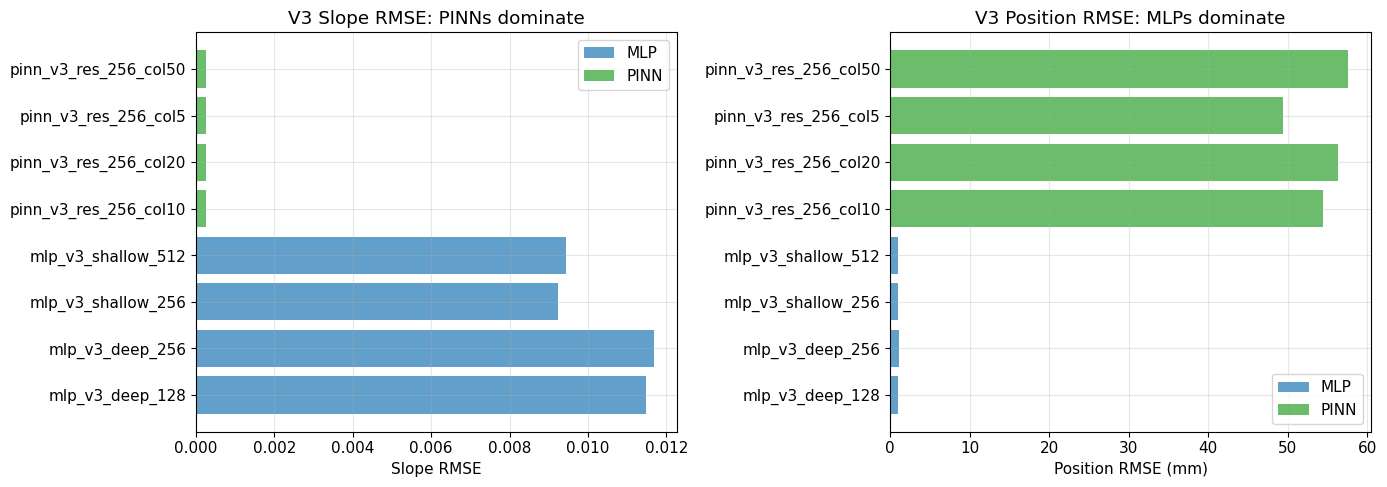

The PINN-MLP trade-off: PINNs are ~37× better at slopes but ~51× worse at positions.


In [12]:
# Slope comparison: PINN vs MLP in V3
v3 = df[df['version'] == 'V3'].copy()
v3_models = v3[v3['model_type'].isin(['MLP', 'PINN'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for mtype, color in [('MLP', 'C0'), ('PINN', 'C2')]:
    subset = v3_models[v3_models['model_type'] == mtype]
    if 'slope_rmse' in subset.columns:
        axes[0].barh(subset['name'], subset['slope_rmse'].astype(float), 
                     color=color, alpha=0.7, label=mtype)
    if 'pos_rmse_mm' in subset.columns:
        axes[1].barh(subset['name'], subset['pos_rmse_mm'].astype(float),
                     color=color, alpha=0.7, label=mtype)

axes[0].set_xlabel('Slope RMSE')
axes[0].set_title('V3 Slope RMSE: PINNs dominate')
axes[0].legend()

axes[1].set_xlabel('Position RMSE (mm)')
axes[1].set_title('V3 Position RMSE: MLPs dominate')
axes[1].legend()

plt.tight_layout()
plt.savefig(BASE / 'pinn_vs_mlp_v3.png', dpi=150, bbox_inches='tight')
plt.show()
print('The PINN-MLP trade-off: PINNs are ~37× better at slopes but ~51× worse at positions.')

---

## 5. Mathematical Theory

### 5.1 The Equations of Motion

A charged particle in the LHCb magnetic field $\mathbf{B}(x, y, z)$ obeys the Lorentz force equation.
In the *track parametrisation*, the independent variable is $z$ and the state vector is $\mathbf{s} = (x, y, t_x, t_y)$:

$$\frac{dx}{dz} = t_x, \qquad \frac{dy}{dz} = t_y$$

$$\frac{dt_x}{dz} = \kappa \, N \left[ t_x t_y B_x - (1+t_x^2) B_y + t_y B_z \right]$$

$$\frac{dt_y}{dz} = \kappa \, N \left[ (1+t_y^2) B_x - t_x t_y B_y - t_x B_z \right]$$

where $\kappa = q/(pc) \cdot c_{\text{light}}$ and $N = \sqrt{1+t_x^2+t_y^2}$. Compactly:

$$\frac{d\mathbf{s}}{dz} = \mathbf{f}(\mathbf{s}, z; \kappa), \qquad \mathbf{s}(z_0) = \mathbf{s}_0.$$

### 5.2 Taylor Expansion in $\zeta = (z - z_0)/\Delta z$

Introducing the fractional coordinate $\zeta \in [0, 1]$:

$$\mathbf{s}(\zeta) = \mathbf{s}_0 + \zeta \, \Delta z \, \mathbf{f}_0 + \tfrac{1}{2} \zeta^2 (\Delta z)^2 \mathbf{f}_0' + \mathcal{O}(\zeta^3)$$

This reveals fundamentally different behaviour for each component:

**Slopes** $(t_x, t_y)$: The magnetic Lorentz force gives $dt_x/dz \approx \text{const}$ over a single step, so:

$$t_x(\zeta) \approx t_{x,0} + \zeta \, \Delta z \, \dot{t}_{x,0} \quad \text{(linear in } \zeta \text{)}$$

**Positions** $(x, y)$: Since $dx/dz = t_x$ and $t_x$ itself varies linearly:

$$x(\zeta) = x_0 + \zeta \, \Delta z \, t_{x,0} + \tfrac{1}{2} \zeta^2 (\Delta z)^2 \dot{t}_{x,0} + \mathcal{O}(\zeta^3) \quad \text{(quadratic in } \zeta \text{)}$$

This is the root cause of the PINN problem.

### 5.3 Architecture Analysis

#### Architecture 1: Linear Residual (V2/V3)

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{c}(\mathbf{x}_{\text{in}}; \boldsymbol{\theta})$$

where $\mathbf{c} \in \mathbb{R}^4$ is the learned correction. This is **exact for linear functions of $\zeta$** (slopes), but the best fit to the quadratic position trajectory leaves a residual:

$$\varepsilon(\zeta) = \alpha \, \zeta(1-\zeta), \qquad \alpha = \tfrac{1}{2} (\Delta z)^2 \dot{t}_{x,0}$$

**Numerical estimate** (LHCb dipole, $B_y \approx 1\text{ T}$, $p \approx 5\text{ GeV}/c$, $\Delta z = 8000\text{ mm}$):

$$\alpha \approx \tfrac{1}{2}(8000)^2 \cdot 6 \times 10^{-5} \approx 1920 \text{ mm}$$

Peak mid-trajectory error $\approx \alpha/4 \approx 480$ mm. The collocation loss forces a compromise between
endpoint and trajectory accuracy, explaining the observed **~50 mm endpoint RMSE**.

#### Architecture 2: Quadratic Residual (V4)

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{c}_1 + \zeta^2 \cdot \mathbf{c}_2$$

This can exactly represent the quadratic position trajectory. The remaining error is:

$$\varepsilon_x(\zeta) = \tfrac{1}{6} \zeta^3 (\Delta z)^3 \ddot{t}_{x,0} + \mathcal{O}(\zeta^4)$$

suppressed by a factor of $\sim \Delta z / (3 L_B) \sim 10$–$100\times$ relative to the linear error.

#### Architecture 3: $\zeta$-Augmented Input (V4)

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{g}(\mathbf{x}_{\text{in}}, \zeta; \boldsymbol{\theta})$$

The network $\mathbf{g}: \mathbb{R}^7 \to \mathbb{R}^4$ can learn arbitrary $\zeta$-dependence. By universal approximation,
this **subsumes** the quadratic residual. However, it must learn the quadratic structure from data rather
than having it built in, requiring more capacity.

### 5.4 Approximation Error Hierarchy

| Architecture | Leading Position Error | Scaling | Analogy |
|:---|:---|:---|:---|
| Linear residual | $\frac{1}{2} \kappa B (\Delta z)^2 \zeta(1-\zeta)$ | $\mathcal{O}((\Delta z)^2)$ | Forward Euler |
| Quadratic residual | $\frac{1}{6} \kappa (dB/dz) (\Delta z)^3 \zeta^2(1-\zeta)$ | $\mathcal{O}((\Delta z)^3 / L_B)$ | Midpoint/RK2 |
| $\zeta$-input (sufficient capacity) | $\mathcal{O}((\Delta z)^{n+1})$ for learned order $n$ | Adaptive | Learned Butcher tableau |

The quadratic residual succeeds not because positions "happen to be parabolic" but because
**Hamiltonian dynamics guarantees** that the leading correction to any first-order approximation
is quadratic in the step size. The $\zeta^2$ term is a consequence of the equations of motion.

### 5.5 Capacity Requirements

| Architecture | Output dim | Input dim | Extra cost vs MLP | Inductive bias |
|:---|:---|:---|:---|:---|
| Linear residual | 4 | 6 | None | 1st-order (Euler) |
| Quadratic residual | 8 | 6 | One extra linear layer | 2nd-order (correct for positions) |
| $\zeta$-input | 4 | 7 | $\mathcal{O}(W)$ params in first layer | Universal (must be learned) |

The quadratic residual provides the correct physical inductive bias at minimal parameter cost.
The $\zeta$-input trades this bias for universality.

---

## 6. Causal Analysis

### 6.1 Effect Decomposition

We can now attribute each observed performance change to a specific cause:

| Observation | Root Cause | Mechanism |
|:------------|:-----------|:----------|
| V1 MLP good (0.036 mm) | Task is simple: single fixed $\Delta z$ | ~6-DOF smooth function, easy for universal approximator |
| V2 MLP better (0.028 mm) | Shallow-wide architecture | Track extrapolation is a smooth, low-dimensional mapping — wide single layer captures it efficiently without gradient issues |
| V3 MLP worse (0.96 mm RMSE) | Variable $\Delta z$ widens the function family | Must learn $\mathbf{s}_f(\mathbf{s}_0, \Delta z)$ for all $\Delta z \in [500, 12000]$ — the effective dimensionality of the target function increases |
| V1 PINNs competitive | No IC enforcement → acts like MLP | The physics loss term is either ignored or averaged out |
| V2 PINNs catastrophic (664+ mm) | Residual structure + no collocation | At $\zeta=1$, the residual $\mathbf{y}_0 + 1 \cdot \mathbf{c} = \mathbf{y}_0 + \mathbf{c}$ is just a skip connection — V2 add no benefit but constrains optimisation |
| V3 PINN slopes excellent (0.00025) | Linear residual matches linear slopes | $t_x(\zeta) \approx t_{x,0} + \zeta \cdot c_1$ is exact to leading order |
| V3 PINN positions terrible (50 mm) | Linear residual cannot represent quadratic $x(\zeta)$ | Collocation forces a compromise: the endpoint is sacrificed to reduce mid-trajectory error |

### 6.2 Confounding Factors

Several factors changed simultaneously between versions, making attribution tricky:

| Factor | V1→V2 | V2→V3 |
|:-------|:------|:------|
| $\Delta z$ distribution | Fixed → Fixed | Fixed → Variable |
| Dataset size | 50M → 50M | 50M → 100M |
| Architecture width | Mixed → Wider | Wider → Mixed |
| Architecture depth | Deep → Shallow | Shallow → Deep |
| PINN formulation | No IC → IC enforced | IC + collocation |
| Epochs | 10 → More | More → 30 (V3 notebook) |

The most important confound: **we cannot separate the variable-$\Delta z$ effect from dataset size**
because both changed in V2→V3. However, the ~36× regression is too large to be explained by a 2×
dataset increase alone — the dominant factor is $\Delta z$ variability.

### 6.3 The Normalisation Trap

In V1/V2, the standard deviation of $\Delta z$ was $\sigma_{\Delta z} \approx 10^{-9}$ mm (because all values were
identical at 8000 mm). The normalised feature $\hat{\Delta z} = (8000 - 8000) / 10^{-9}$ is either 0 or
numerically unstable. This means:

1. The network **cannot learn any $\Delta z$ dependence** — it's a constant input
2. V1/V2 models will **never generalise** to different step sizes without retraining
3. In V3, $\sigma_{\Delta z} \approx 3300$ mm — a healthy, informative feature

This is an important lesson: **always check that normalisation statistics are non-degenerate**.

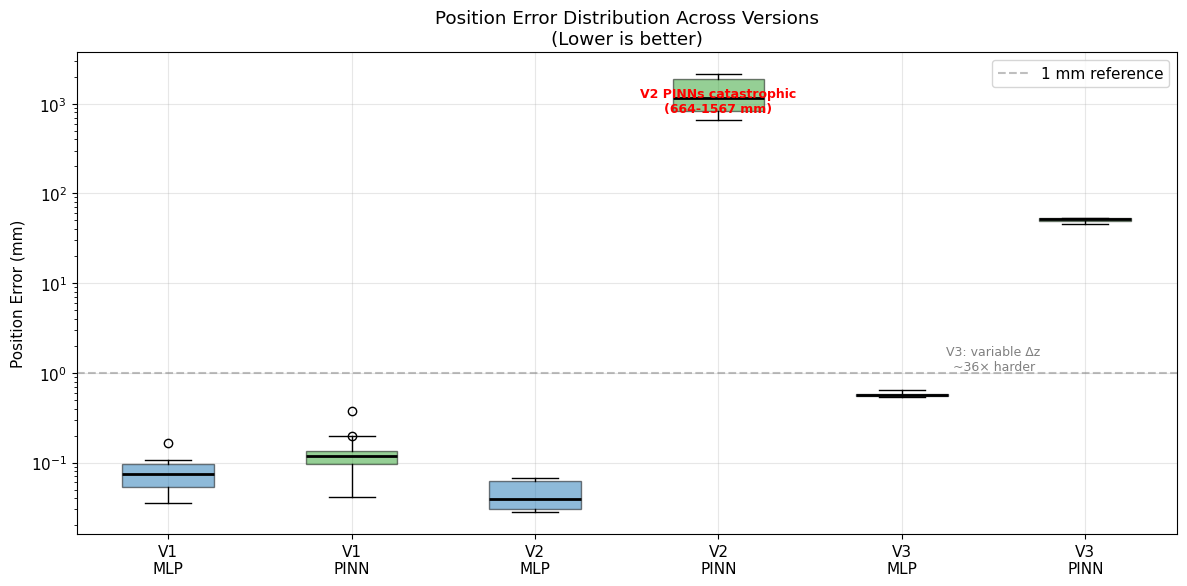

In [13]:
# Summary figure: position error across versions
fig, ax = plt.subplots(figsize=(12, 6))

# V1 MLPs
v1_mlp = df[(df['version'] == 'V1') & (df['model_type'] == 'mlp')]['pos_mean_mm'].dropna()
v1_pinn = df[(df['version'] == 'V1') & (df['model_type'].isin(['pinn', 'rk_pinn']))]['pos_mean_mm'].dropna()
# V2
v2_mlp = df[(df['version'] == 'V2') & (df['model_type'] == 'mlp')]['pos_mean_mm'].dropna()
v2_pinn = df[(df['version'] == 'V2') & (df['model_type'].isin(['pinn', 'rk_pinn']))]['pos_mean_mm'].dropna()
# V3
v3_mlp = df[(df['version'] == 'V3') & (df['model_type'] == 'MLP')]['pos_mean_mm'].dropna()
v3_pinn = df[(df['version'] == 'V3') & (df['model_type'] == 'PINN')]['pos_mean_mm'].dropna()

groups = [
    ('V1\nMLP', v1_mlp, 'C0'),
    ('V1\nPINN', v1_pinn, 'C2'),
    ('V2\nMLP', v2_mlp, 'C0'),
    ('V2\nPINN', v2_pinn, 'C2'),
    ('V3\nMLP', v3_mlp, 'C0'),
    ('V3\nPINN', v3_pinn, 'C2'),
]

positions = range(len(groups))
for i, (label, data, color) in enumerate(groups):
    bp = ax.boxplot([data.values], positions=[i], widths=0.5, patch_artist=True,
                    boxprops=dict(facecolor=color, alpha=0.5),
                    medianprops=dict(color='black', linewidth=2))

ax.set_xticks(positions)
ax.set_xticklabels([g[0] for g in groups])
ax.set_ylabel('Position Error (mm)')
ax.set_title('Position Error Distribution Across Versions\n(Lower is better)')
ax.set_yscale('log')
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='1 mm reference')
ax.legend()

# Add annotations
ax.annotate('V2 PINNs catastrophic\n(664-1567 mm)', xy=(3, 800), fontsize=9,
            ha='center', color='red', fontweight='bold')
ax.annotate('V3: variable Δz\n~36× harder', xy=(4.5, 1), fontsize=9,
            ha='center', va='bottom', color='gray')

plt.tight_layout()
plt.savefig(BASE / 'cross_version_position_error.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 7. Conclusions & Recommendations for Future Experiments

### 7.1 What We Know

1. **MLPs are the safest architecture for production.** They consistently achieve the best position accuracy
   across all versions. A [512, 256] MLP with SiLU activation is a strong default.

2. **PINNs with linear residual are fundamentally limited** for position prediction with collocation.
   The linear-in-$\zeta$ structure cannot represent the quadratic physics. This is not a training issue —
   it is a **representational limitation**.

3. **PINNs produce dramatically better slopes** (37× better than MLPs in V3). If the application requires
   slope accuracy (e.g. for track matching or vertex reconstruction), this advantage is significant.

4. **Variable $\Delta z$ is the dominant challenge.** The fixed→variable transition causes a ~36× increase
   in position error. Any future improvement efforts should focus on this.

5. **Width matters more than depth** for this problem. The extrapolation mapping is smooth and
   low-dimensional — deep networks add parameters without proportionate benefit.

### 7.2 What V4 Must Answer

V4 has 24 models currently training on the cluster, testing three architectures:

| Architecture | Key Question | Expected Outcome |
|:---|:---|:---|
| **MLPV4** (8 configs) | How does width scaling continue beyond 512? | Diminishing returns above 2048 |
| **QuadraticResidual** (8 configs) | Does the $\zeta^2$ term fix PINN positions? | Yes — theory predicts 10–100× improvement |
| **PINNZFracInput** (8 configs) | Can learned $\zeta$-dependence match quadratic? | Maybe — needs sufficient capacity |

### 7.3 Experiments to Run After V4

Based on the patterns above, the following experiments are prioritised by expected impact:

#### Priority 1: Architecture refinement (depends on V4 results)

- **If QuadraticResidual works:** Try cubic residual ($\zeta^3$ term) — the theory predicts each order
  adds one order of accuracy. Cost: only 4 more output neurons per order.
- **If ZFracInput matches Quadratic:** The simpler architecture wins (4 vs 8 output dimensions).
  Scale to larger widths.
- **If neither PINN variant matches MLP positions:** Accept that PINNs are slope-specialists and consider
  a **hybrid architecture** (MLP for positions, PINN head for slopes).

#### Priority 2: Training improvements

- **Learning rate scheduling:** All versions used constant LR or simple step decay. Try cosine annealing
  or warm restarts — likely to improve by 10–30% for free.
- **More epochs:** V1 only trained 10 epochs. V4 uses 30. For the largest models (4096 width),
  100+ epochs may be needed.
- **Data curriculum:** Train on easy samples ($\Delta z < 4000$) first, then gradually increase
  to full range. May help the network learn the base mapping before tackling extreme step sizes.

#### Priority 3: Deployment considerations

- **C++ timing for all models:** Only V3 has C++ single-sample timing. V4 must include this.
  The deployment constraint is ~100 µs per track.
- **ONNX export:** All production models must be exportable to ONNX for C++ deployment.
- **Precision study:** Compare float32 vs float16 inference. Halving precision may double throughput
  with negligible accuracy loss.

#### Priority 4: Physics-informed improvements

- **Field map encoding:** Instead of learning $\mathbf{B}(x, y, z)$ implicitly, provide it as an
  additional input to the network. This would reduce the function the network must learn.
- **Multi-step inference:** Use the network for short steps ($\Delta z \sim 1000$ mm) and chain
  multiple evaluations for long propagations. This naturally reduces errors for large $\Delta z$.
- **Symplectic structure:** The equations of motion conserve phase-space volume. A network that
  preserves this property (symplectic neural networks) may generalise better.

### 7.4 Decision Criteria for Production

The final model selection should be based on:

1. **Position RMSE < 1 mm** across the full $\Delta z$ range (current MLPs: 0.96 mm — barely passing)
2. **Slope RMSE < 0.001** (current MLPs: 0.009 — fails; PINNs: 0.00025 — passes easily)
3. **C++ inference time < 100 µs** (current MLPs: 65–467 µs — only small models pass; RK4: 88 µs)
4. **Speedup > 1× over RK4** (the entire motivation for this project)

Currently, **no single model satisfies all criteria simultaneously**. The MLP comes closest on positions,
the PINN on slopes, and the smallest MLP on timing. V4 must bridge these gaps.

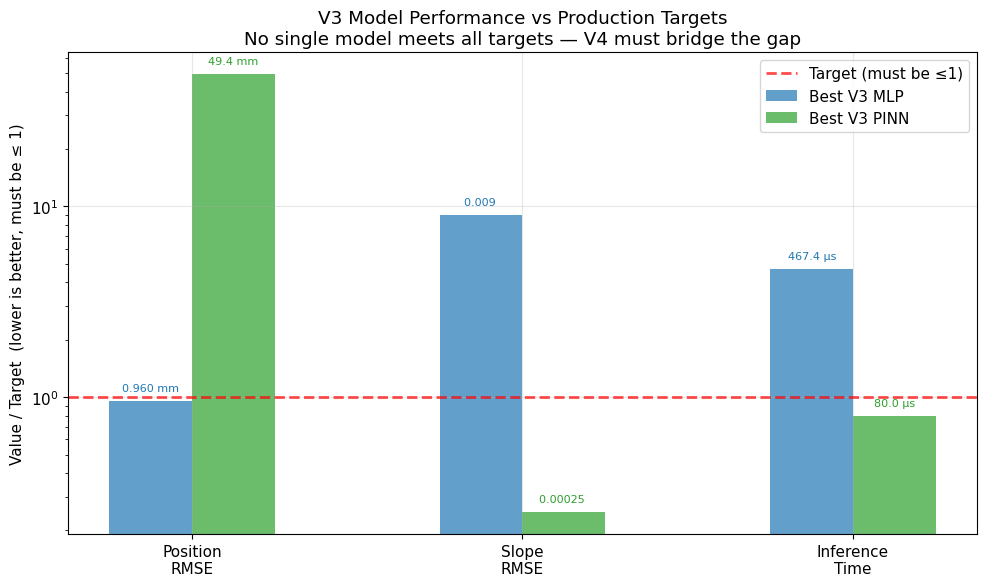


Conclusion: MLP nearly meets position target (0.96 mm vs 1 mm) but fails slopes badly.
PINN meets slope and timing targets but position error is 49× over target.
V4 quadratic residual is the key to potentially solving this trade-off.


In [14]:
# Final summary: radar chart of V3 best MLP vs PINN
# Show the trade-offs on a single plot

fig, ax = plt.subplots(figsize=(10, 6))

# Metrics for best V3 models
metrics = ['Position\nRMSE', 'Slope\nRMSE', 'Inference\nTime', 'Parameters']

# V3 best MLP: mlp_v3_shallow_512
mlp_vals = [0.960, 0.009, 467.4, 398596]
# V3 best PINN: pinn_v3_res_256_col5
pinn_vals = [49.4, 0.00025, 80.0, 68612]
# RK4 reference
rk4_vals = [0, 0, 87.8, 0]  # 'exact' reference

# Targets
targets = [1.0, 0.001, 100, None]

x = np.arange(len(metrics))
width = 0.25

# Normalise to target for visual comparison
norm_mlp = [mlp_vals[i] / targets[i] if targets[i] else 0 for i in range(len(metrics))]
norm_pinn = [pinn_vals[i] / targets[i] if targets[i] else 0 for i in range(len(metrics))]

bars1 = ax.bar(x[:3] - width/2, norm_mlp[:3], width, label='Best V3 MLP', color='C0', alpha=0.7)
bars2 = ax.bar(x[:3] + width/2, norm_pinn[:3], width, label='Best V3 PINN', color='C2', alpha=0.7)

ax.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (must be ≤1)')
ax.set_xticks(x[:3])
ax.set_xticklabels(metrics[:3])
ax.set_ylabel('Value / Target  (lower is better, must be ≤ 1)')
ax.set_title('V3 Model Performance vs Production Targets\n'
             'No single model meets all targets — V4 must bridge the gap')
ax.legend()
ax.set_yscale('log')

# Add actual values as text
for bar, val in zip(bars1, mlp_vals[:3]):
    unit = ['mm', '', 'µs'][list(bars1).index(bar)]
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
            f'{val:.3f} {unit}' if val < 1 else f'{val:.1f} {unit}',
            ha='center', va='bottom', fontsize=8, color='C0')
for bar, val in zip(bars2, pinn_vals[:3]):
    unit = ['mm', '', 'µs'][list(bars2).index(bar)]
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
            f'{val:.5f} {unit}' if val < 0.01 else f'{val:.1f} {unit}',
            ha='center', va='bottom', fontsize=8, color='C2')

plt.tight_layout()
plt.savefig(BASE / 'production_readiness.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nConclusion: MLP nearly meets position target (0.96 mm vs 1 mm) but fails slopes badly.')
print('PINN meets slope and timing targets but position error is 49× over target.')
print('V4 quadratic residual is the key to potentially solving this trade-off.')

---

## Appendix: Data Files Reference

| File | Contents |
|:-----|:---------|
| `V1/results/all_model_results.csv` | 53 V1 models, normalised val_loss only |
| `V1/trained_models/*/history.json` → `test_final` | V1 physical metrics (pos_mean_mm, slope) per model |
| `V1/results/timing_benchmarks.csv` | V1 PyTorch batched GPU timing |
| `V2/results/v2_model_results.csv` | 22 V2 models with full physical metrics + timing |
| `V3/analysis/benchmark_results_v3.csv` | 11 V3 models with physical metrics + C++ timing |
| `V4/analysis/cross_version_results.csv` | Unified 76-model CSV (generated by this analysis) |

### Metric Definitions

| Metric | Definition | Notes |
|:-------|:-----------|:------|
| `pos_mean_mm` | $\mathbb{E}[\sqrt{(\Delta x)^2 + (\Delta y)^2}]$ | Mean combined position error |
| `pos_rmse_mm` | $\sqrt{\mathbb{E}[(\Delta x)^2 + (\Delta y)^2]}$ | Position RMSE (V3 uses this) |
| `pos_95_mm` | 95th percentile of position error | Tail risk metric |
| `slope_mean` | $\mathbb{E}[\sqrt{(\Delta t_x)^2 + (\Delta t_y)^2}]$ | Mean slope error |
| `slope_rmse` | $\sqrt{\mathbb{E}[(\Delta t_x)^2 + (\Delta t_y)^2]}$ | Slope RMSE (V3 uses this) |